![Py4Eng](img/logo.png)

# Differential equations
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)

# Deterministic differential equations
## Coupled spring-mass system

![Springs figure](https://scipy.github.io/old-wiki/pages/Cookbook/two_springs_diagramd4f6.png?action=AttachFile&do=get&target=two_springs_diagram.png)

Two objects with masses $m_1$ and $m_2$ and displacement $x_1$ and $x_2$ are coupled through springs with spring constants $k_1$ and $k_2$. The left end of the left spring is fixed. We assume that the lengths of the springs, when subjected to no external forces, are $L_1$ and $L_2$.

The masses are sliding on a surface that creates friction, so there are two friction coefficients, $b_1$ and $b_2$. 

The deterministic differential equations are:

$$
m_1 x_1'' = - b_1 x_1' - k_1 (x_1 - L_1) + k_2 (x_2 - x_1 - L_2) \\
m_2 x_2'' = - b_2 x_2' - k_2 (x_2 - x_1 - L_2) 
$$

This is a pair of coupled second order equations. To solve this system with one of the ODE solvers provided by *SciPy*, we must first convert this to a system of first order differential equations. We introduce two variables

$$
y_1 = x_1' \\
y_2 = x_2'
$$

These are the velocities of the masses. 

With a little algebra, we can rewrite the two second order equations as the following system of four first order equations:

$$
x_1' = y_1 \\
y_1' = (-b_1 y_1 - k_1 (x_1 - L_1) + k_2 (x_2 - x_1 - L_2))/ m_1 \\
x_2' = y_2 \\
y_2' = (-b_2 y_2 - k_2 (x_2 - x_1 - L_2)) / m_2
$$

These equations are now in a form that we can implement in Python.

The following code defines the "right hand side" of the system of equations (also known as a vector field). Note that the arguments of the function `vectorfield` are configured to be used with the `odeint` function: the dependent variable is first (`w=(x_1, y_1, x_2, y_2)`), the independent varialbe (i.e. time, `t`) is the second argument, the problem parameters follow.

In [2]:
def vectorfield(w, t, *p):
    """Defines the differential equations for the coupled spring-mass system.

    Arguments
    ---------
     w :  np.ndarray
         vector of the state variables: w = [x1, y1, x2, y2]
     t :  float
         time
     p :  tuple 
         problem parameters: p = (m1, m2, k1, k2, L1, L2, b1, b2) 
    """
    x1, y1, x2, y2 = w
    m1, m2, k1, k2, L1, L2, b1, b2 = p

    # return x1', y1', x2', y2'
    return (
        y1,
        (-b1 * y1 - k1 * (x1 - L1) + k2 * (x2 - x1 - L2)) / m1,
        y2,
        (-b2 * y2 - k2 * (x2 - x1 - L2)) / m2
    )    

In [3]:
# Parameter values
# Masses:
m1 = 1.0
m2 = 1.5
# Spring constants
k1 = 8.0
k2 = 40.0
# Natural lengths
L1 = 0.5
L2 = 1.0
# Friction coefficients
b1 = 0.8
b2 = 0.5

# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
x1 = 0.5
y1 = 0.0
x2 = 2.25
y2 = 0.0
w0 = x1, y1, x2, y2

# Create the time samples for the output of the ODE solver
t = np.linspace(0, 10, 250)

# Solve
solution = odeint(vectorfield, w0, t, args=(m1, m2, k1, k2, L1, L2, b1, b2))
x1, y1, x2, y2 = solution[:,0], solution[:,1], solution[:,2], solution[:,3]

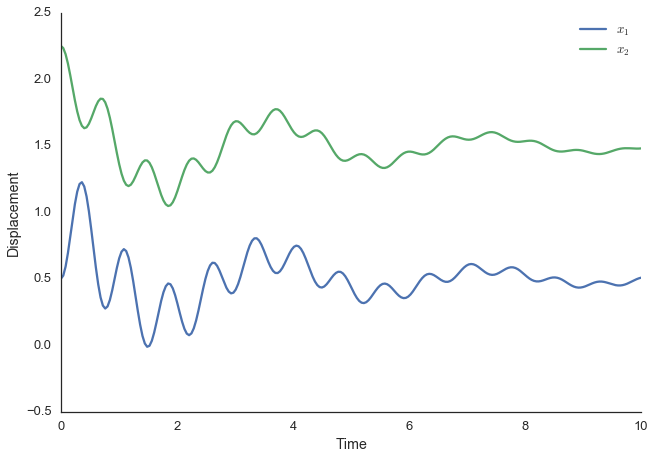

In [4]:
plt.plot(t, x1, label=r'$x_1$')
plt.plot(t, x2, label=r'$x_2$')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()
sns.despine()

To really explore the solution, we can use the `interact` decorator from the [ipywidgets](https://github.com/ipython/ipywidgets) pakcage. This will add sliders to control the problem parameters, which will allow us to easily explore how the solutions look.

Install it with `conda install ipywidgets` or `pip install ipywidgets`.

In [9]:
from ipywidgets import interact

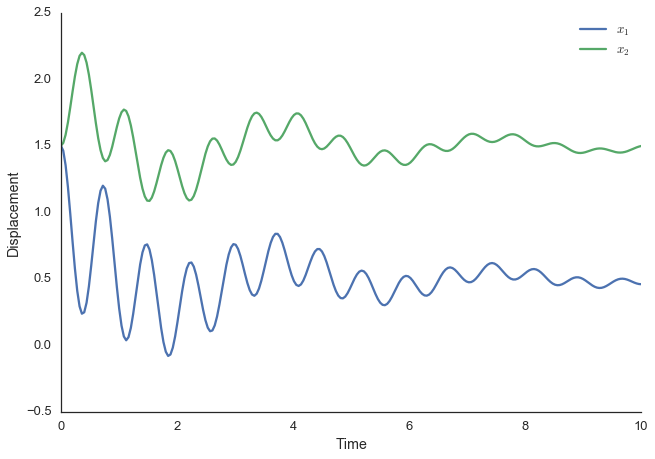

In [6]:
@interact(x1=(0.0, 3.0), y1 = (-1.0, 1.0), x2 = (0.0, 3.0), y2 = (-1.0, 1.0), maxt=10.0)
def springs(x1, y1, x2, y2, maxt):    
    w0 = [x1, y1, x2, y2]
    t = np.linspace(0, maxt, 250)
    solution = odeint(vectorfield, w0, t, args=(m1, m2, k1, k2, L1, L2, b1, b2))
    plt.plot(t, solution[:,0], label=r'$x_1$')
    plt.plot(t, solution[:,2], label=r'$x_2$')
    plt.xlabel('Time')
    plt.ylabel('Displacement')
    plt.legend()
    sns.despine()

## Exercise

Integrate the [Lorentz' system](https://en.wikipedia.org/wiki/Lorenz_system):
$$
\frac{dx}{dt} = \alpha ( y - x) \\
\frac{dy}{dt} = x ( \rho - z) -y \\
\frac{dz}{dt} = xy - \beta z
$$

Plot a solution with four figure panels: 
- x(t), y(t), z(t)
- y(x)
- z(y)
- z(x)

See [solution code](https://github.com/yoavram/Py4Eng/blob/master/solutions/lorentz_system.py).

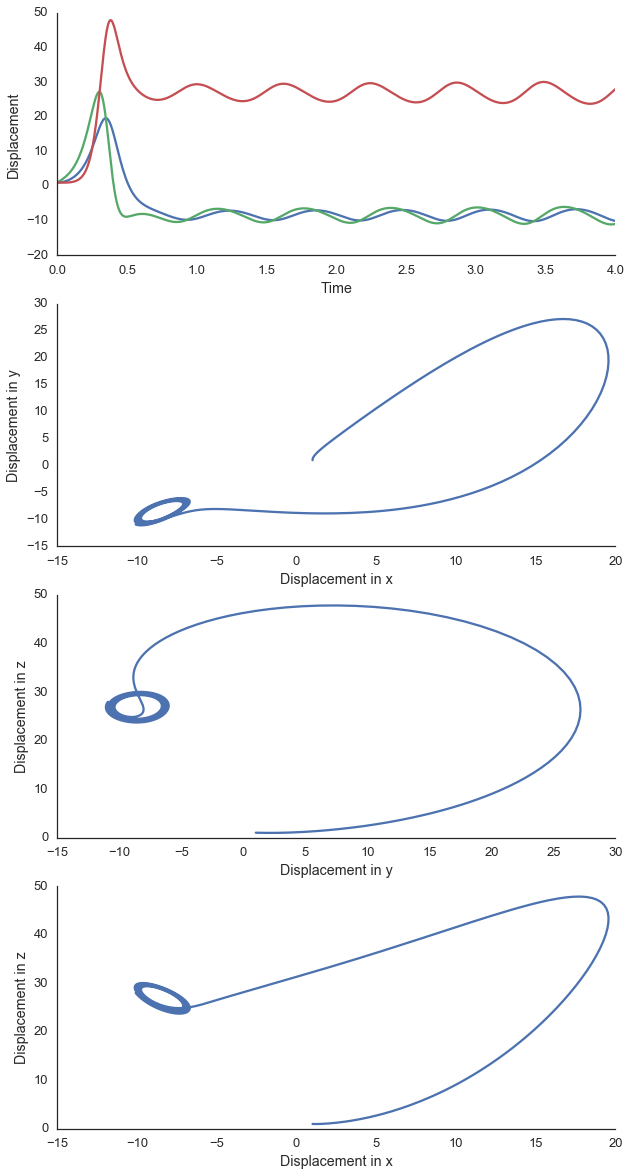

In [30]:
alpha = 10
rho = 28
beta = 8/3

# Your code here

# Stochastic differential equations

Stochastic differential equations or SDE are differential equations are used to model systems with both a deterministic influence and a random influence. The simplest example is the motion of a massive Brownian particle under the influence of friction ([Ornstein–Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)). 

We will use the [sdeint](https://github.com/mattja/sdeint) solver. Install it with `pip install sdeint` (version 0.2.0 may have trouble installing, get version 0.2.1).

In [3]:
import sdeint
print("sdeint version:", sdeint.__version__)

sdeint version: 0.2.1


## Stochastic spring fluctuation

Consider a spring with a contant $k$ moving under friction with coefficient $\gamma$ in the presence of thermal fluctuations with temperature $T$. The length of the spring $y(t)$ will fluctuate stochastically around the spring rest length $y^*$ and its dynamics can be described by an Ito equation:

$$
dy = f(y,t)dy + G(y,t) dW
$$

where $f(y,t) = \theta (y^* - y)$, $G = \sqrt{2 D}$, $\theta=k/\gamma$ and $D$ is the effective diffusion constant ($D=k_B T  / \gamma$).

In [4]:
help(sdeint.itoint)

Help on function itoint in module sdeint.integrate:

itoint(f, G, y0, tspan)
    Numerically integrate Ito equation  dy = f dt + G dW



In [5]:
theta = 1.0
ystar = 1.0
D = 0.045

In [6]:
def f(y, t): 
    return theta * (ystar - y)
def G(y, t): 
    return np.sqrt(2 * D)

y0 = 1.2
t = np.linspace(0, 20, 1000)
y = sdeint.itoint(f, G, y0, t)

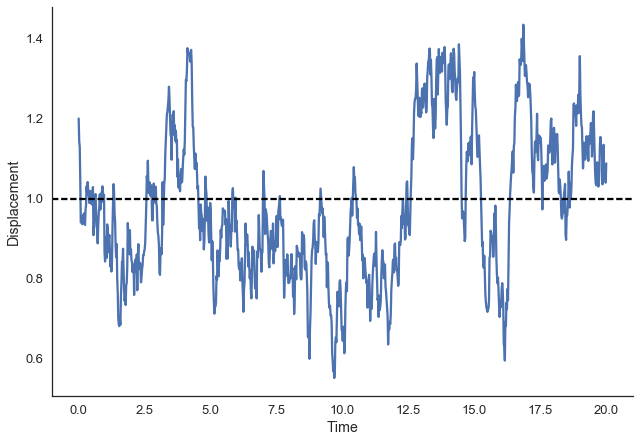

In [7]:
plt.plot(t, y, '-')
plt.axhline(ystar, ls='--', color='k')
plt.xlabel('Time')
plt.ylabel('Displacement')
sns.despine()

Let's plot 5 solutions of the SDE - 5 independent springs - and add some widgets so that we can control the problem parameters:

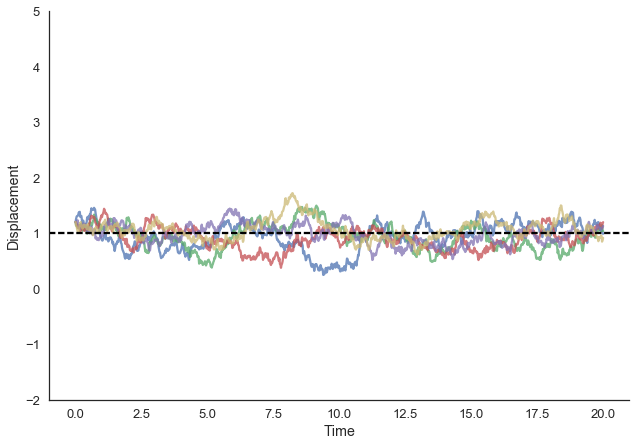

In [10]:
@interact(theta=(0, 2), y0=(0, 2), ystar=(0, 2), logD=(-3.0, 0), maxt=(0, 50, 20))
def stoch_dynamics(theta, y0, ystar, logD, maxt):    
    y0 = 1.2
    t = np.linspace(0, maxt, 1000)
    y = np.empty((1000, 5))
    for i in range(5):
        y[:, i] = sdeint.itoint(f, G, y0, t).ravel()
    plt.plot(t, y, '-', alpha=0.75)
    plt.axhline(ystar, ls='--', color='k')
    plt.ylim(-2, 5)
    plt.xlabel('Time')
    plt.ylabel('Displacement')
    sns.despine()

# References

- [A coupled spring-mass system](https://scipy.github.io/old-wiki/pages/Cookbook/CoupledSpringMassSystem.html) / The SciPy Cookbook
- [Ornstein–Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process#Application_in_physical_sciences) / Wikipedia
- [Stochastic differential equations](http://www.azimuthproject.org/azimuth/show/Stochastic+differential+equation) / Azimuth project
- [sdeint](https://github.com/mattja/sdeint): Numerical integration of Ito or Stratonovich SDEs.
- [ipywidgets](https://github.com/ipython/ipywidgets): the notebook widgets

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.0, [IPython](http://ipython.org/) 5.2.2, [Jupyter](http://jupyter.org) 4.3.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)